In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [2]:
#read data
df = pd.read_csv('copper-new.txt', header=None, sep='\s+')
df.head()

,0,1
0,0.591,24.41
1,4.703,54.98
2,9.470,89.57
3,11.615,114.26
4,12.970,133.61


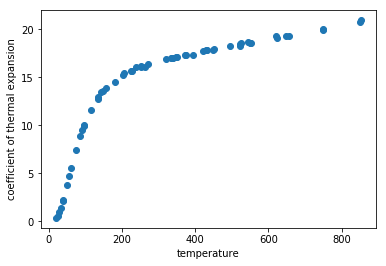

In [3]:
#Plotting the relationship between the 2 features
plt.scatter(df[1], df[0])
plt.xlabel('temperature')
plt.ylabel('coefficient of thermal expansion')
plt.show()

#### 1) Perform linear regression on the data. Report the fitted model and the fitting error.

In [4]:
#Let's get the intercept and coefficients, using the same regression model with sklearn
X = df[[1]]
y = df[0]
#splitting to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#Fit the linear model
model1 = LinearRegression()
results = model1.fit(X_train,y_train)
#print the coefficients
print('intercept: ',model1.intercept_)
print('coefficients: ', model1.coef_[0])
#prediction
y_pred = model1.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))

intercept:  7.440640229144395
coefficients:  0.02169922097290207
MSE:  12.986921759444277


Our simple linear model - y = 7.44 + 0.0217x

#### Perform nonlinear regression with polynomial regression function up to degree n = 10 and use ridge regression (see Lecture Slides for “Bias-Variance Tradeoff”). Write down your formulation and strategy for doing this, the form of the ridge regression.

In [6]:
def polynomial_ridge(X, y, poly_degree):
    polynomial_features= PolynomialFeatures(degree=poly_degree)
    X_new = polynomial_features.fit_transform(X)
    #Splitting to train test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
    #gridsearch with ridge
    parameters = {'alpha':np.arange(0, 10, 0.1)}
    # define the model/ estimator
    model = Ridge(normalize=True)
    # define the grid search
    ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
    ridge_reg = ridge_reg.fit(X_train, y_train)
    #prediction 
    return ridge_reg, mean_squared_error(y_test, ridge_reg.predict(X_test))
    

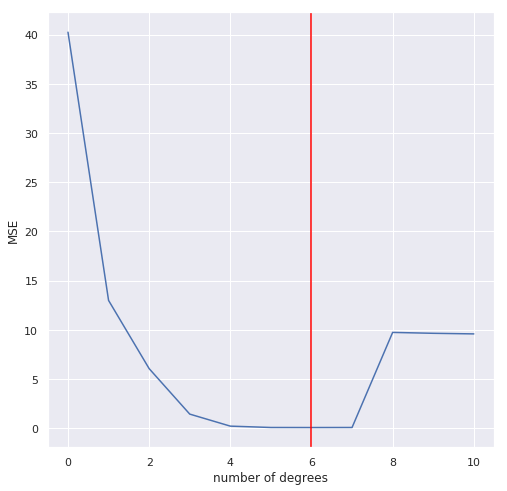

In [7]:
degrees = np.arange(11)
poly_ridge_dict = {}
for degree in degrees:
    _, poly_ridge_dict[degree] = polynomial_ridge(X, y, degree)
    
sns.set()
f = plt.figure(figsize=(8,8))
plt.plot(poly_ridge_dict.keys(), poly_ridge_dict.values())
plt.axvline(x=np.argmin(pd.Series(poly_ridge_dict)), color='red')
plt.xlabel('number of degrees')
plt.ylabel('MSE')
plt.show()

Comment: For polynomial degree I built a ridge model. In order to find the best alpha parameter in the ridge model, I used grid search. With the model, I calculated the MSE on the test set. Eventually I had an MSE value for each of the ridge models. I took the model where the polynomial degree is 6, because it has the lowest MSE among them.

#### Comment 2:
I only now read that we just need to describe the steps and treat our model like it is with degree=10.
Steps: 
First, we will perform a cross validation to find our lambda.
For every polynomial degree I will find its best lambda and then I will fit the ridge regression and calculate its MSE and then compare against the other models. 

(For part 2, you have to describe the steps and no need to consider polynomial regression from n=1 to 10, only degree = 10 is applied in Q2 partb.) 

In [8]:
#Preparing polynomail ridge regression with degrees equal to 10
ridge_10 = polynomial_ridge(X, y, poly_degree=10)
ridge_10

(GridSearchCV(cv=None, error_score=nan,
              estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                              max_iter=None, normalize=True, random_state=None,
                              solver='auto', tol=0.001),
              iid='deprecated', n_jobs=None,
              param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,...7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
        5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
        6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
        7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
        9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
              pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
              scoring='neg_mean_squared_error'

#### Use 5 fold cross validation to select the optimal regularization parameter λ. Plot the cross validation curve and report the optimal λ.

In [52]:
#looping over lambdas and perform Kfold on each one of them to find the CV MSE.
polynomial_features= PolynomialFeatures(degree=10)
X_new = polynomial_features.fit_transform(X)
#Splitting to train test and doing kfold 
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)
kfold = KFold(n_splits=5)

alphas = np.arange(0.01, 1, 0.01)
result_dict = {}
for alpha in alphas:
    mse_list = []

    for train, test in kfold.split(X_train):
            model = Ridge(normalize=True, alpha=alpha)
            model = model.fit(X_train[train], y_train.iloc[train])
            y_pred = model.predict(X_train[test])
            mse_list.append(mean_squared_error(y_train.iloc[test], y_pred))
            
    result_dict[alpha] = sum(mse_list) / kfold.n_splits

In [54]:
#plotting CV MSE vs the lambdas
#sns.set()
#f = plt.figure(figsize=(8,8))
#plt.plot(result_dict.keys(), result_dict.values(), 'r--')
#plt.xlabel('lambda')
#plt.ylabel('CV MSE')
#plt.show()

#### Predict the coefficient at 400 degree Kelvin using both models. Comment on how would you compare the accuracy of predictions.

I will test the simple linear model with the optimized model from part 2(with 10 degrees of freedom and optimized alpha.).

In [11]:
#simple linear regression model - 
print("prediction for linear regression: ",model1.predict(np.array(400).reshape(1,1)))
#optimized ridge regression with polynomial degree=10 - 
optimized_series = pd.Series(result_dict)
best_alpha = optimized_series.index[np.argmin(result_dict)]

model2 = Ridge(normalize=True, alpha=best_alpha)
model2 = model2.fit(X_train, y_train)
ridge_pred = model2.predict(polynomial_features.transform(np.array(400).reshape(1,1)))
print("prediction for ridge regression: ", ridge_pred)

prediction for linear regression:  [16.12032862]
prediction for ridge regression:  [18.27715219]


Comment: In regression models we can use adj. R^2 to compare the which model performs better. We can also use AIC,BIC to compare between models. 